In [1]:
# Extracting the S&P 500 stocks 
import yfinance as yf 
import pandas as pd
from itertools import combinations
from skopt import gp_minimize
import random
from scipy.stats import pearsonr
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from matplotlib import pyplot as plt
import numpy as npF
from statistics import mean 
%matplotlib inline

In [2]:
found_pairs = [
    (('EXPD', 'MLM'), _),
    (('CMS', 'RTX'), _),
    (('FE', 'WEC'), _),
    (('AWK', 'HOLX'), _),
    (('BEN', 'FRT'), _),
    (('HSIC', 'UPS'), _),
    (('ES', 'TSCO'), _),
    (('GE', 'TTWO'), _),
    (('ENPH', 'WBD'), _),
    (('SCHW', 'USB'), _),
    (('AVGO', 'KLAC'), _),
    (('SRE', 'VICI'), _),
    (('DIS', 'T'), _),
    (('AVB', 'LOW'), _),
    (('BAX', 'TECH'), _),
    (('IR', 'TDG'), _),
    (('KIM', 'NSC'), _)
]


In [5]:
start_date = "2024-01-01"
end_date = "2025-01-01"

def get_close_prices(start_date, end_date):
    # Step 1: Get S&P 500 tickers from Wikipedia
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_table = pd.read_html(url)[0]  # First table contains stock symbols

    # Extract tickers
    sp500_tickers = sp500_table["Symbol"].tolist()
    sp500_data = yf.download(sp500_tickers, start= start_date , end = end_date, auto_adjust = False)  # Download only 10 for demo

    # Extracting only the Close Prices
    list_of_na_columns = []
    close_price = sp500_data["Close"]
    for i in close_price:
        if close_price[i].isna().sum() > 1:
            list_of_na_columns.append(i)

    close_price = close_price.drop(columns = list_of_na_columns)
    return close_price
close_price = get_close_prices(start_date, end_date ) 

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2025-01-01)')


In [6]:
import warnings
warnings.filterwarnings('ignore')

## Traditional Pairs Trading

In [10]:
import numpy as np
import pandas as pd
import quantstats as qs
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt

def pairs_trading_strategy(close_price, found_pairs, initial_capital=100000, window_size=10, entry_threshold=2.0, exit_threshold=0.5, target_vol=0.002, commission_rate=0.003):
    capital_series = pd.Series(dtype='float64')
    daily_pnl = pd.Series(dtype='float64')
    all_daily_returns = pd.DataFrame()

    for pair in found_pairs:
        stock1, stock2 = pair[0]
        Y = close_price[stock1]
        X = close_price[stock2]

        # Linear regression for hedge ratio
        X_with_const = sm.add_constant(X)
        model = OLS(Y, X_with_const).fit()
        hedge_ratio = model.params[1]
        
        spread = Y - hedge_ratio * X
        spread_mean = spread.rolling(window=window_size).mean()
        spread_std = spread.rolling(window=window_size).std()
        zscore = (spread - spread_mean) / spread_std
        zscore = zscore.dropna()

        if zscore.empty:
            continue  # Skip if not enough data to compute spread

        stock1_position = pd.Series(0, index=zscore.index)
        stock2_position = pd.Series(0, index=zscore.index)

        # Compute rolling volatility
        stock1_vol = close_price[stock1].pct_change().rolling(window_size).std()
        stock2_vol = close_price[stock2].pct_change().rolling(window_size).std()

        # Adjust position sizing based on volatility
        if target_vol > 0:
            position_size_stock_1 = target_vol / (stock1_vol + 1e-8)  # Avoid division by zero
            position_size_stock_2 = target_vol / (stock2_vol + 1e-8)
        else:
            position_size_stock_1 = pd.Series(1, index=stock1_vol.index)
            position_size_stock_2 = pd.Series(1, index=stock2_vol.index)

        position_size_stock_1 = position_size_stock_1.fillna(0)
        position_size_stock_2 = position_size_stock_2.fillna(0)
        
        trade_volume = pd.Series(0, index=stock1_vol.index)
        for i in range(1, len(zscore)):
            if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i - 1] == 0:
                stock1_position.iloc[i] = 1 * position_size_stock_1.iloc[i]
                stock2_position.iloc[i] = -1 * position_size_stock_2.iloc[i]
                trade_volume.iloc[i] += position_size_stock_1.iloc[i] + position_size_stock_2.iloc[i]
            elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i - 1] == 0:
                stock1_position.iloc[i] = -1 * position_size_stock_1.iloc[i]
                stock2_position.iloc[i] = 1 * position_size_stock_2.iloc[i]
                trade_volume.iloc[i] += position_size_stock_1.iloc[i] + position_size_stock_2.iloc[i]

            # Exit condition: Close the positions when zscore crosses the exit threshold
            elif abs(zscore.iloc[i]) < exit_threshold:
                stock1_position.iloc[i] = 0
                stock2_position.iloc[i] = 0
                trade_volume.iloc[i] = trade_volume.iloc[i-1]

            else:
                stock1_position.iloc[i] = stock1_position.iloc[i - 1]
                stock2_position.iloc[i] = stock2_position.iloc[i - 1]
        
        # Compute returns
        stock1_ret = close_price[stock1].loc[zscore.index].pct_change().fillna(0)
        stock2_ret = close_price[stock2].loc[zscore.index].pct_change().fillna(0)
        pair_return = (stock1_ret * stock1_position.shift(1)) + (stock2_ret * stock2_position.shift(1))

        # Scale by capital allocation
        allocation = 1/len(found_pairs) * initial_capital
        pair_dollar_pnl = pair_return * allocation

        # Compute transaction costs
        total_transaction_cost = commission_rate * trade_volume

        # Cost-adjusted P&L
        pair_dollar_pnl -= total_transaction_cost
        all_daily_returns[f"{stock1}-{stock2}"] = pair_dollar_pnl

    # Aggregate portfolio performance
    daily_pnl = all_daily_returns.sum(axis=1)
    capital_series = initial_capital + daily_pnl.cumsum()
    
    # Compute Sharpe ratio
    portfolio_daily_return = capital_series.pct_change().dropna()
    sharpe_ratio = (portfolio_daily_return.mean() / portfolio_daily_return.std()) * np.sqrt(252)
    
    # Compute max drawdown
    rolling_max = capital_series.cummax()
    drawdown = capital_series / rolling_max - 1
    max_drawdown = drawdown.min()

    # Plot results
    capital_series.plot(figsize=(12, 6), title="Portfolio Value Over Time")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True)
    plt.show()

    print("Final Portfolio Value: ${:,.2f}".format(capital_series.iloc[-1]))
    print("Total Return: {:.2f}%".format((capital_series.iloc[-1] / initial_capital - 1) * 100))
    print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
    print("Max Drawdown: {:.2f}%".format(max_drawdown * 100))
    
    return capital_series, sharpe_ratio, max_drawdown

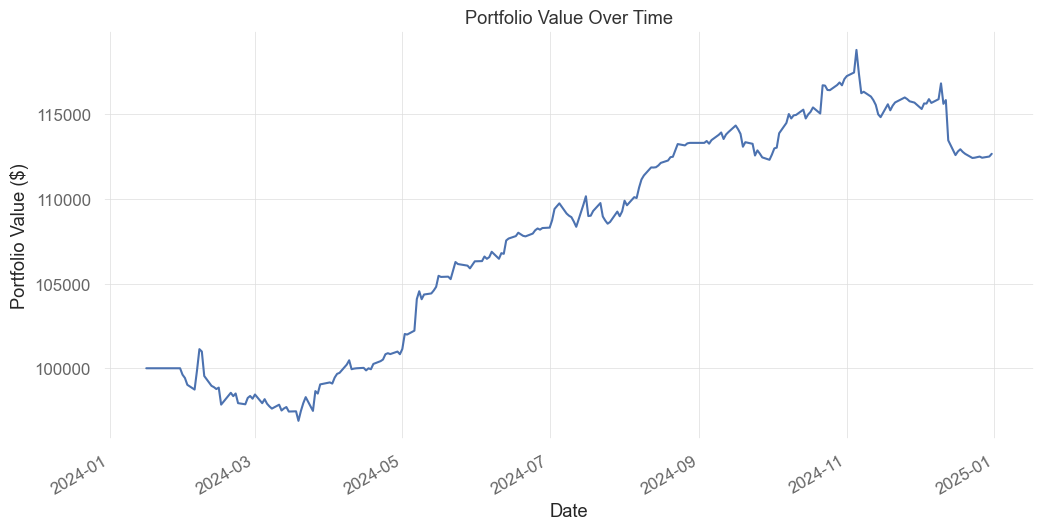

Final Portfolio Value: $112,669.24
Total Return: 12.67%
Sharpe Ratio: 1.87
Max Drawdown: -5.37%


In [12]:
capital_series, sharpe_ratio, max_drawdown = pairs_trading_strategy(close_price, found_pairs, initial_capital=100000, window_size=10, entry_threshold=2.0, exit_threshold=0.5, target_vol=0.02, commission_rate=0.003)

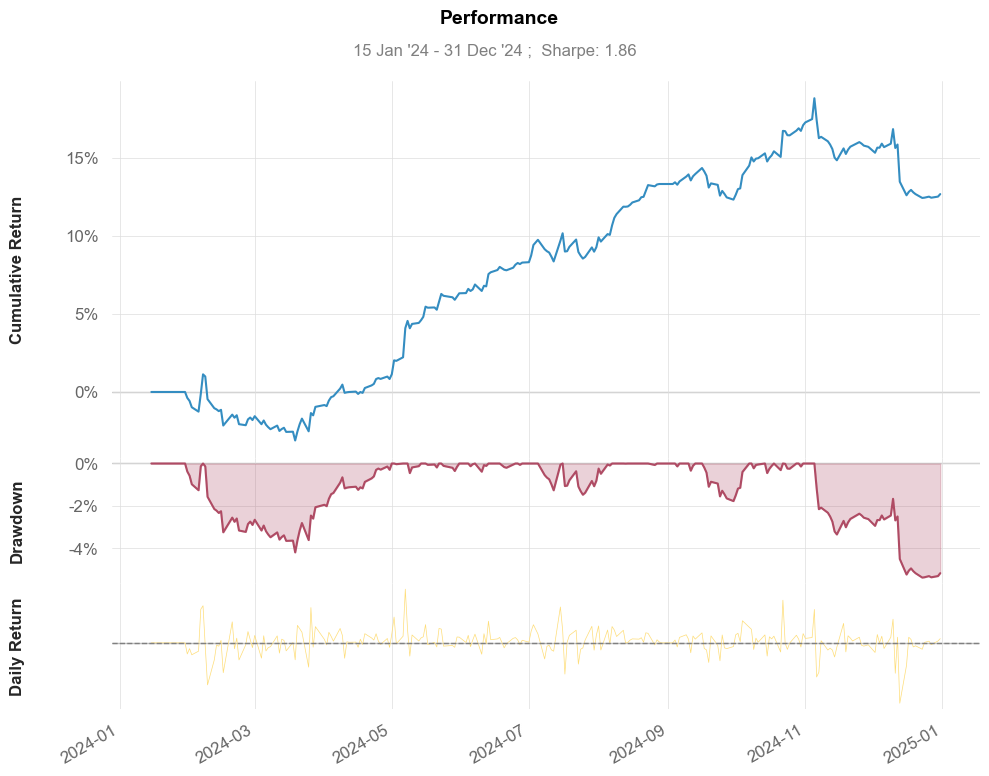

In [14]:
qs.plots.snapshot(capital_series, title='Performance', show=True)

## Trend Following and Buy & Hold

In [17]:
def trend_following_buy_and_hold(stock_ticker, start_date, end_date, window1, window2, initial_investment, commission_rate=0.001):
    # Download stock data
    df = yf.download(stock_ticker, start=start_date, end=end_date, auto_adjust=False)
    df.index = pd.to_datetime(df.index)

    # Compute log returns
    df['log_return_buy_n_hold'] = np.log(df['Adj Close']).diff()
    # Calculate moving averages
    df[f'SMA-{window1}'] = df['Adj Close'].rolling(window1, min_periods=window1).mean().shift(1)
    df[f'SMA-{window2}'] = df['Adj Close'].rolling(window2, min_periods=window2).mean().shift(1)
    
    # Generate trading signals (1: long, 0: no position)
    df['signal'] = np.where(df[f'SMA-{window1}'] > df[f'SMA-{window2}'], 1, 0)
    df['signal'] = np.where(df[f'SMA-{window1}'] < df[f'SMA-{window2}'], -1, df['signal'])
    
    df.dropna(inplace=True)
    
    
    
    # Align signal to execute trades based on yesterday’s signal
    df['signal_shifted'] = df['signal'].shift(1)
    
    # Compute raw strategy returns
    df['log_return_trend_follow'] = df['signal_shifted'] * df['log_return_buy_n_hold']
    
    # Compute transaction costs based on position changes
    df['position_change'] = df['signal_shifted'].diff().abs().fillna(0)
    df['transaction_cost'] = df['position_change'] * commission_rate

    # Subtract transaction cost from log returns
    df['log_return_trend_follow_net'] = df['log_return_trend_follow'] - df['transaction_cost']
    
    # Cumulative returns
    df['cumulative_trend_follow'] = initial_investment * np.exp(df['log_return_trend_follow_net'].cumsum())
    df['cumulative_buy_n_hold'] = initial_investment * np.exp(df['log_return_buy_n_hold'].cumsum())
    
    return df[['cumulative_trend_follow']], df['cumulative_buy_n_hold']
trend_follow, buy_n_hold = trend_following_buy_and_hold('^GSPC', start_date, end_date, window1=5, window2=20, initial_investment=100000)

[*********************100%***********************]  1 of 1 completed


In [19]:
df = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  1 of 1 completed


In [21]:
def compute_metrics(series, initial_capital):
    series = series.squeeze()  # Handle DataFrame or Series input
    returns = series.pct_change().dropna()
    total_return = (series.iloc[-1] / initial_capital - 1) * 100
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    drawdown = series / series.cummax() - 1
    max_drawdown = drawdown.min() * 100
    return {
        'final_value': series.iloc[-1],
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

def plot_all_strategies(traditional_pairs, ml_pairs, trend_follow_series, buy_n_hold_series, initial_capital=100000, title="Comparison of Strategies"):
    traditional_pairs = traditional_pairs.squeeze()
    ml_pairs = ml_pairs.squeeze()
    trend = trend_follow_series.squeeze()
    buyhold = buy_n_hold_series.squeeze()

    # Compute metrics BEFORE alignment
    strategies = [
        {
            'name': 'Traditional Pairs Trading',
            'series': traditional_pairs,
            'metrics': compute_metrics(traditional_pairs, initial_capital)
        },
        {
            'name': 'ML Pairs Trading',
            'series': ml_pairs,
            'metrics': compute_metrics(ml_pairs, initial_capital)
        },
        {
            'name': 'Trend Following',
            'series': trend,
            'metrics': compute_metrics(trend, initial_capital)
        },
        {
            'name': 'Buy & Hold',
            'series': buyhold,
            'metrics': compute_metrics(buyhold, initial_capital)
        }
    ]

    # Sort by total return
    strategies.sort(key=lambda x: x['metrics']['total_return'], reverse=True)

    # Align only for plotting
    # Find common date range across all series
    common_index = set(strategies[0]['series'].index)
    for strat in strategies[1:]:
        common_index = common_index.intersection(set(strat['series'].index))
    common_index = sorted(common_index)

    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 7))
    lines, labels = [], []

    for strat in strategies:
        aligned_series = strat['series'].loc[common_index]
        label = (f"{strat['name']}\n"
                 f"Final: ${strat['metrics']['final_value']:.2f} | "
                 f"Return: {strat['metrics']['total_return']:.1f}% | "
                 f"Sharpe: {strat['metrics']['sharpe']:.2f} | "
                 f"Max DD: {strat['metrics']['max_drawdown']:.1f}%")
        line, = ax1.plot(aligned_series, label=label, linewidth=2)
        lines.append(line)
        labels.append(label)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Portfolio Value ($)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax1.legend(lines, labels, loc='best', fontsize=12)

    plt.title(title)
    ax1.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig("strategy_comparison.png")
    plt.close(fig)


In [29]:
# get returns from ML based strategy 

portfolio_value_ml = pd.read_csv("portfolio_value_ml.csv")
portfolio_value_ml['Date'] = pd.to_datetime(portfolio_value_ml['Date'], dayfirst=True)
portfolio_value_ml.set_index('Date', inplace=True)
portfolio_value_series = portfolio_value_ml['Portfolio Price'].copy()

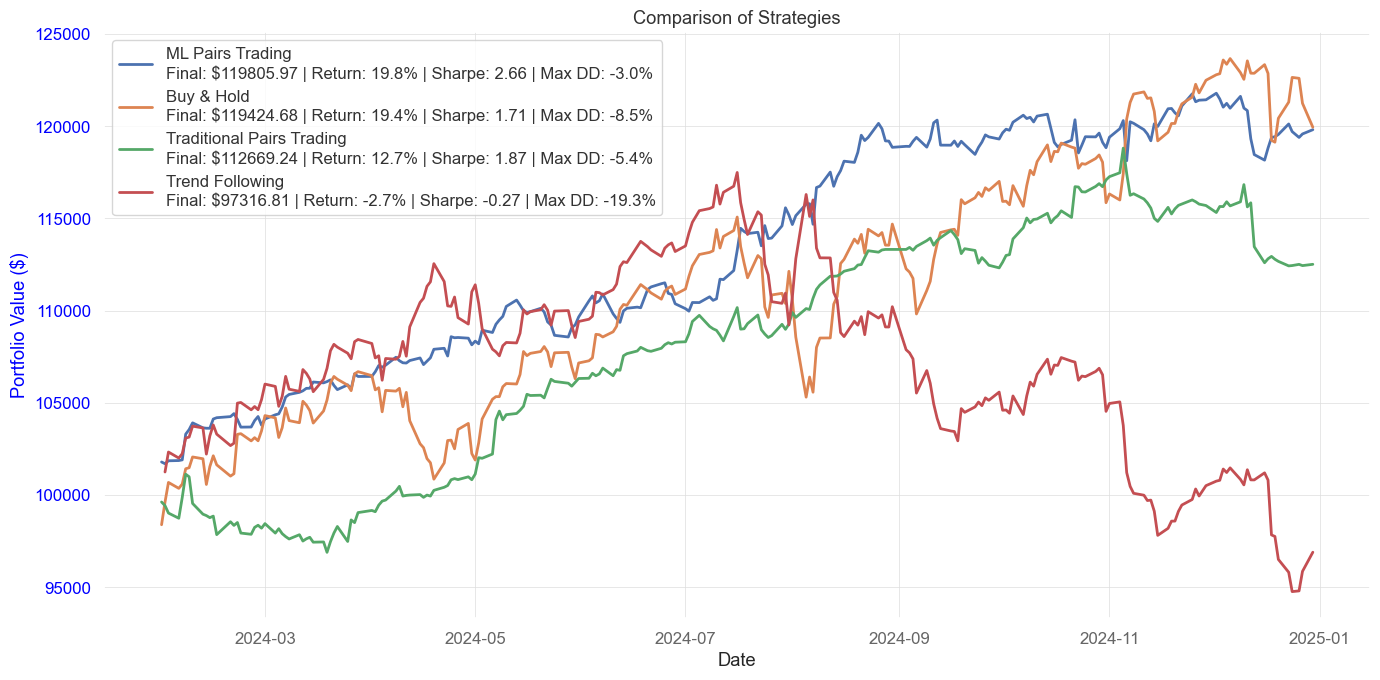

In [31]:
plot_all_strategies(
    traditional_pairs=capital_series,
    ml_pairs = portfolio_value_series,
    trend_follow_series=trend_follow,
    buy_n_hold_series=buy_n_hold,
    initial_capital=100000
)

## Plot Returns and Drawdown of Trend Following Strategy

In [39]:
# Extract the column as a Series
trend_follow_series = trend_follow['cumulative_trend_follow']

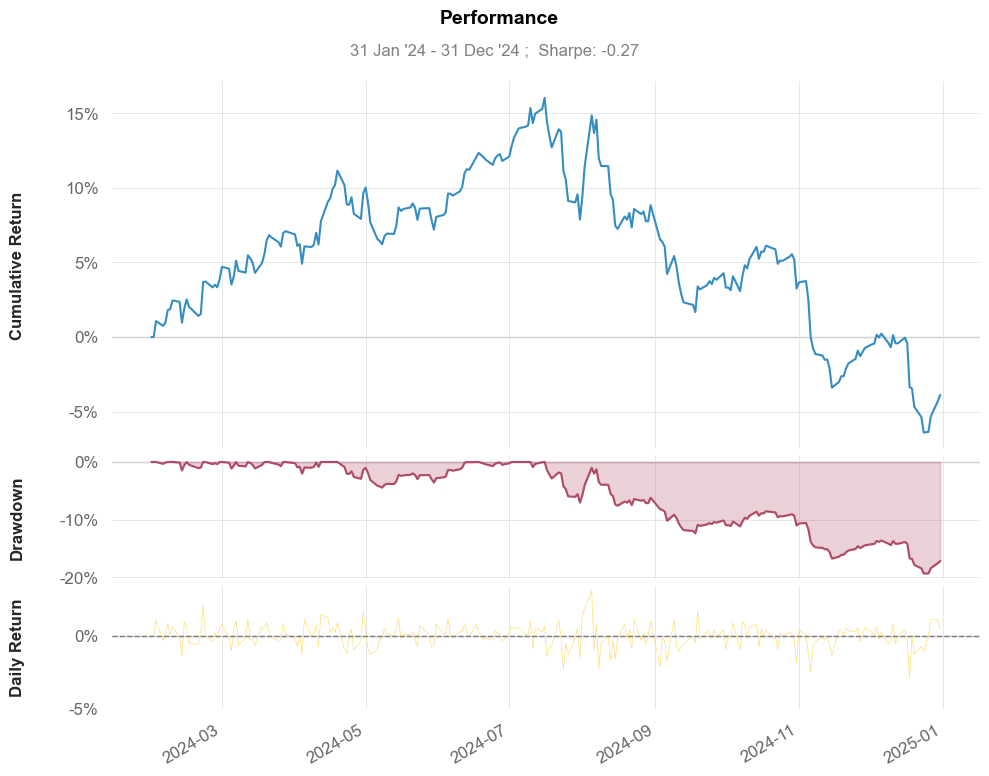

In [41]:
qs.plots.snapshot(trend_follow_series, title='Performance', show=True)